## Import parqet files

In [1]:
from numpy.random import RandomState
from pandas.core.common import random_state

from project_1.loading import load_final_data_without_ICU, load_outcomes
# Load data from parquet file
import pandas as pd
import numpy as np
from project_1.config import PROJ_ROOT, PROCESSED_DATA_DIR

df_a, df_b, df_c = load_final_data_without_ICU()
death_a, death_b, death_c = load_outcomes()


2025-03-30 13:43:32.388 | INFO     | project_1.config:<module>:11 - PROJ_ROOT path is: C:\Users\tilma\OneDrive\Studium\_Machine Learning for Healthcare\Projects


Shapes of the datasets:
Set A: (183416, 42) Set B: (183495, 42) Set C: (183711, 42)
Shapes of labels:
Set A: (4000, 2) Set B: (4000, 2) Set C: (4000, 2)


In [56]:
run_efficient = True

In [2]:
print(df_a.describe())
print(df_a.columns)

            RecordID                           Time         Gender  \
count  183416.000000                         183416  183416.000000   
mean   137604.313779  2025-03-10 23:59:34.798273280       0.562081   
min    132539.000000            2025-03-10 00:00:00       0.000000   
25%    135072.000000            2025-03-10 12:00:00       0.000000   
50%    137590.000000            2025-03-11 00:00:00       1.000000   
75%    140101.000000            2025-03-11 12:00:00       1.000000   
max    142673.000000            2025-03-12 00:00:00       1.000000   
std      2923.639911                            NaN       0.496002   

             Height        Weight           Age       Albumin   Cholesterol  \
count  1.834160e+05  1.834160e+05  1.834160e+05  1.834160e+05  1.834160e+05   
mean   6.454295e-15  4.456582e-16 -2.810931e-16 -5.493248e-16  2.112266e-16   
min   -5.158858e+00 -2.611045e+00 -2.835966e+00 -2.482836e+00 -3.083051e+00   
25%   -7.575847e-01 -6.533555e-01 -6.537587e-01 -7.95

# Q4.1 Prompting an LLM to solve a time-series problem

## Patient Summary short
only includes the most important data, without much noise

In [3]:
def generate_summary_statistical(patient_df):
    features = {}
    # Assuming df is already filtered for a single patient
    features['age'] = patient_df['Age'].iloc[0]
    features['gender'] = "male" if patient_df['Gender'].iloc[0] == 1 else "female"

    summary = [
        f"Patient is a {int(features['age']*40+60)}-year-old {features['gender']}. Over the first 48 hours:"
    ]

    vital_vars = ['HeartRate', 'SaO2', 'WBC', 'Urine', 'pH', 'Lactate']
    for var in vital_vars:
        if var not in patient_df.columns: continue
        values = patient_df[var].dropna()
        if len(values) == 0: continue
        min_val, max_val = values.min(), values.max()
        mean_val, last_val = values.iloc[-1], values.iloc[-1]
        summary.append(f"- {var} ranged from {min_val:.2f} to {max_val:.2f}, avg: {mean_val:.2f}, last: {last_val:.2f}")
        
    return "\n".join(summary)


## Patient Summary trends
Summarize variable behavior over three time segments (0–16h, 16–32h, 32–48h) using trends: increasing, decreasing, stable, or fluctuating. Adds a temporal element that can help the LLM infer progression.

In [4]:
def get_trend_label(seq):
    if len(seq) < 2: return "unknown"
    d1, d2, d3 = np.mean(seq[:len(seq)//3]), np.mean(seq[len(seq)//3:2*len(seq)//3]), np.mean(seq[2*len(seq)//3:])
    if d1 < d2 < d3: return "↑"
    elif d1 > d2 > d3: return "↓"
    elif abs(d1 - d2) < 0.1 and abs(d2 - d3) < 0.1: return "→"
    else: return "~"

def generate_summary_trend(patient_df):
    features = {}
    features['age'] = patient_df['Age'].iloc[0]
    features['gender'] = "male" if patient_df['Gender'].iloc[0] == 1 else "female"

    summary = [
        f"Patient is a {int(features['age']*40+60)}-year-old {features['gender']}. Over the first 48 hours:"
    ]

    vital_vars = ['HeartRate', 'SaO2', 'WBC', 'Urine', 'pH', 'Lactate']
    for var in vital_vars:
        if var not in patient_df.columns: continue
        series = patient_df[var].dropna().values
        if len(series) < 3: continue
        trend = get_trend_label(series)
        summary.append(f"- {var} shows a trend of {trend}")

    return "\n".join(summary)


In [19]:
def generate_patient_summaries(df):
    result_rows = []

    for rid, group in df.groupby("RecordID"):
        summary_stat = generate_summary_statistical(group)
        summary_trend = generate_summary_trend(group)

        result_rows.append({
            "RecordID": rid,
            "summary_statistical": summary_stat,
            "summary_trend": summary_trend
        })

    return pd.DataFrame(result_rows)

# ---------- Usage ---------- #

# Assuming df_a is your full DataFrame
summaries_a = generate_patient_summaries(df_a)
summaries_a = summaries_a.merge(death_a, on="RecordID", how="left")

summaries_b = generate_patient_summaries(df_b)
summaries_b = summaries_b.merge(death_b, on="RecordID", how="left")

summaries_c = generate_patient_summaries(df_c)
summaries_c = summaries_c.merge(death_c, on="RecordID", how="left")

# Show a few example summaries
summaries_a.head(2)

,RecordID,summary_statistical,summary_trend,In-hospital_death
0,132539.0,Patient is a 36-year-old female. Over the firs...,Patient is a 36-year-old female. Over the firs...,0
1,132540.0,Patient is a 86-year-old male. Over the first ...,Patient is a 86-year-old male. Over the first ...,0


In [10]:
print(summaries_a.loc[0, "summary_statistical"])
print()
print(summaries_a.loc[0, "summary_trend"])

Patient is a 36-year-old female. Over the first 48 hours:
- SaO2 ranged from -15.50 to 1.00, avg: 0.50, last: 0.50
- WBC ranged from -0.96 to 2.19, avg: -0.30, last: -0.30
- Urine ranged from -0.40 to 3.20, avg: 1.60, last: 1.60
- pH ranged from -3.50 to 1.00, avg: -1.37, last: -1.37
- Lactate ranged from -0.75 to 4.00, avg: -0.25, last: -0.25

Patient is a 36-year-old female. Over the first 48 hours:
- SaO2 shows a trend of ~
- WBC shows a trend of ↓
- Urine shows a trend of ↑
- pH shows a trend of ~
- Lactate shows a trend of ~


### Ollama Test

In [15]:
from ollama import chat
from ollama import ChatResponse

response: ChatResponse = chat(model='gemma3:1b', messages=[
    {
    'role': 'system',
    'content': 'You are a helpful assistant who explains things clearly and concisely. Your answes are always very short, maximum 100 letters.',
  },
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])
print(response['message']['content'])
response
# or access fields directly from the response object
# print(response.message.content)

The sky is blue because of a process called Rayleigh scattering. Sunlight is made up of all the colors of the rainbow. When sunlight enters the atmosphere, it collides with tiny air particles. Blue light is scattered more than other colors because it travels in shorter distances. That's why we see blue light coming from all directions – it's scattered everywhere!

Essentially, it's like throwing a handful of glitter into a blue pool - the glitter spreads out in all directions. 😊


ChatResponse(model='gemma3:1b', created_at='2025-03-30T11:57:53.1741022Z', done=True, done_reason='stop', total_duration=3701993800, load_duration=53498700, prompt_eval_count=47, prompt_eval_duration=224723200, eval_count=99, eval_duration=3421446700, message=Message(role='assistant', content="The sky is blue because of a process called Rayleigh scattering. Sunlight is made up of all the colors of the rainbow. When sunlight enters the atmosphere, it collides with tiny air particles. Blue light is scattered more than other colors because it travels in shorter distances. That's why we see blue light coming from all directions – it's scattered everywhere!\n\nEssentially, it's like throwing a handful of glitter into a blue pool - the glitter spreads out in all directions. 😊", images=None, tool_calls=None))

In [47]:
from ollama import embed

response = embed(model='deepseek-r1:1.5b', input=summaries_a.loc[0, "summary_statistical"])
np.array(response.get("embeddings", []), dtype=float)

array([[ 0.00593305, -0.00663425,  0.00859711, ..., -0.02073968,
         0.00256301, -0.01139753]])

### Result Calculation

In [16]:
system_prompt_binary = """You are a clinical risk prediction assistant designed to assess the likelihood of in-hospital mortality based on structured patient summaries derived from ICU time-series data. 

You will be provided with a concise, pre-processed text description of a patient's vital signs and lab measurements recorded during the first 48 hours of their ICU stay. Your task is to classify whether the patient is at risk of dying during their hospital stay.

Respond ONLY with a single number:
- `1` if the patient is at high risk of death.
- `0` if the patient is likely to survive.

Do not provide any explanations, reasoning, or text. Only return the number `0` or `1`.
"""

In [20]:
system_prompt_score = """You are a clinical risk prediction assistant designed to assess the likelihood of in-hospital mortality based on structured patient summaries derived from ICU time-series data. 

You will be provided with a concise, pre-processed text description of a patient's vital signs and lab measurements recorded during the first 48 hours of their ICU stay. Your task is to determine the patient risk of dying during their hospital stay.

Your goal is to assess the patient's risk of in-hospital mortality on a scale from 1 to 10:
- `1` means extremely low risk (highly likely to survive).
- `10` means extremely high risk (very likely to die in hospital).

Respond with a single integer between 1 and 10. Do not include explanations, context, or additional output. Return only the number.
"""

In [24]:
from ollama import chat
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd
import re

# ---- Utility: Extract score or binary ---- #

def extract_score_from_response(text, mode="score"): 
    """
    Extracts a number from model output or interprets binary label.
    """
    text = text.lower()
    
    if mode == "score":
        match = re.search(r'(\d+(\.\d+)?)', text)
        if match:
            val = float(match.group(1))
            return min(max(val, 1.0), 10.0) / 10.0  # normalize 1-10 to 0-1
    
    else:  # binary mode
        # Try extracting a number first
        match = re.search(r'(\d+(\.\d+)?)', text)
        if match:
            val = float(match.group(1))
            # Normalize 0–100 or 1–10 range to 0–1 if needed
            if val == 1.0 or val == 0.0:
                return val
            else: 
                print(f"Binary response didn't work: {text}")

        # Fallback to keyword heuristics
        if any(word in text for word in ["yes", "high", "die", "likely"]):
            return 1.0
        elif any(word in text for word in ["no", "low", "survive", "unlikely"]):
            return 0.0

    return 0.5  # fallback neutral

# ---- Few-shot formatter ---- #

def generate_few_shot_examples(df_train, text_col = "summary_statistical" , label_col = "In-hospital_death", max_examples=3, mode="score"):
    """
    Creates few-shot context examples from labeled training set.
    """
    examples = df_train.sample(n=max_examples, random_state=42)
    formatted = "### Examples\n"
    for _, row in examples.iterrows():
        label = row[label_col]
        label_text = f"{int(label * 9 + 1)}/10" if mode == "score" else f"{label}"
        formatted += f"Input:\n{row[text_col]}\nAnswer: {label_text}\n\n"
    return formatted.strip()

# ---- Core inference function ---- #

def query_llm_gemma(summary_text, mode = "score", few_shot_context=None):
    """
    Calls gemma3:1b model via ollama.chat using user prompt.
    """
    user_prompt = f"{few_shot_context}\n\n### Task \nInput:\n{summary_text}\nAnswer:" if few_shot_context else f"Input:\n{summary_text}\nAnswer:"
    
    response = chat(model='gemma3:1b', messages=[{
        'role': 'system',
        'content': system_prompt_score if mode == "score" else system_prompt_binary,
    },
        {
        'role': 'user',
        'content': user_prompt
    }])
    
    return response['message']['content']

# ---- Full evaluation runner ---- #

def evaluate_llm_predictions(summary_df,  text_col='summary_statistical', label_col = "In-hospital_death" , mode="score",
                              few_shot=False, df_train_for_examples=None):
    """
    Runs inference across all rows in summary_df and returns performance + predictions.
    """
    predictions = []
    labels = summary_df[label_col].values

    # Build few-shot context once
    context = None
    if few_shot and df_train_for_examples is not None:
        context = generate_few_shot_examples(df_train_for_examples, text_col, mode=mode)

    for _, row in summary_df.iterrows():
        summary = row[text_col]
        llm_output = query_llm_gemma(summary, mode, few_shot_context=context)
        score = extract_score_from_response(llm_output, mode=mode)
        predictions.append(score)

    predictions = np.array(predictions)

    try:
        auroc = roc_auc_score(labels, predictions)
        auprc = average_precision_score(labels, predictions)
    except:
        auroc = None
        auprc = None

    return {
        "predictions": predictions,
        "true_labels": labels,
        "auroc": auroc,
        "auprc": auprc
    }

### Results

In [30]:
summaries_b_small = summaries_b.sample(5, random_state = 1)
summaries_b_small

,RecordID,summary_statistical,summary_trend,In-hospital_death
200,143195.0,Patient is a 100-year-old female. Over the fir...,Patient is a 100-year-old female. Over the fir...,0
1078,145382.0,Patient is a 82-year-old male. Over the first ...,Patient is a 82-year-old male. Over the first ...,0
610,144174.0,Patient is a 79-year-old male. Over the first ...,Patient is a 79-year-old male. Over the first ...,0
2159,148176.0,Patient is a 26-year-old male. Over the first ...,Patient is a 26-year-old male. Over the first ...,0
1169,145642.0,Patient is a 61-year-old male. Over the first ...,Patient is a 61-year-old male. Over the first ...,1


In [31]:
from itertools import product

summary_cols = ['summary_statistical', 'summary_trend']
prompt_modes = ['zero-shot', 'few-shot']
score_modes = ['binary', 'score']

# Loop through all combinations
for summary_col, prompt_mode, score_mode in product(summary_cols, prompt_modes, score_modes):
    kwargs = {
        'summary_df': summaries_b_small,
        'text_col': summary_col,
        'mode': score_mode,
    }
    
    label = f"{prompt_mode.title()} | {summary_col} | {score_mode} mode"
    
    # Add few-shot parameters if needed
    if prompt_mode == 'few-shot':
        kwargs['few_shot'] = True
        kwargs['df_train_for_examples'] = summaries_a
    
    results = evaluate_llm_predictions(**kwargs)
    print(f"{label} → AUROC: {results['auroc']:.3f}, AUPRC: {results['auprc']:.3f}")

Zero-Shot | summary_statistical | binary mode → AUROC: 0.500, AUPRC: 0.200
Zero-Shot | summary_statistical | score mode → AUROC: 0.375, AUPRC: 0.200
Few-Shot | summary_statistical | binary mode → AUROC: 1.000, AUPRC: 1.000
Few-Shot | summary_statistical | score mode → AUROC: 0.625, AUPRC: 0.333
Zero-Shot | summary_trend | binary mode → AUROC: 0.750, AUPRC: 0.333
Zero-Shot | summary_trend | score mode → AUROC: 0.125, AUPRC: 0.200
Few-Shot | summary_trend | binary mode → AUROC: 0.500, AUPRC: 0.200
Few-Shot | summary_trend | score mode → AUROC: 0.375, AUPRC: 0.250


# Q4.2 Using LLs to retrieve embeddings

In [48]:
import numpy as np
import pandas as pd
from ollama import embed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def get_embedding_ollama(text: str, model_name='deepseek-r1:1.5b'):
    """
    Calls the Ollama embedding API for a given string.
    """
    response = embed(model=model_name, input=text)
    return np.array(response.get("embeddings", []), dtype=float)

def build_embeddings(df, summary_col="summary_statistical", model_name='deepseek-r1:1.5b'):
    """
    For each row in the DataFrame, get an embedding and corresponding label.
    """
    embeddings = []
    labels = []

    for _, row in df.iterrows():
        text = row[summary_col]
        label = row["In-hospital_death"]
        emb = get_embedding_ollama(text, model_name=model_name)
        embeddings.append(emb)
        labels.append(label)

    return np.vstack(embeddings), np.array(labels)

def train_and_evaluate(train_X, train_y, test_X, test_y):
    clf = LogisticRegression(max_iter=2000)
    clf.fit(train_X, train_y)
    probs = clf.predict_proba(test_X)[:, 1]

    auroc = roc_auc_score(test_y, probs)
    auprc = average_precision_score(test_y, probs)
    return probs, auroc, auprc

def visualize_tsne(embeddings, labels, title="t-SNE of Embeddings"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.colorbar(scatter, label="In-hospital Death (0/1)")
    plt.title(title)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.show()


### LLMs embeddings with Statistical Summary

In [38]:
summaries_a_small = summaries_a.sample(100, random_state = 1)

In [49]:
if run_efficient:
    train_X, train_y = build_embeddings(summaries_a_small, summary_col="summary_statistical", model_name='deepseek-r1:1.5b')
    test_X, test_y = build_embeddings(summaries_b_small, summary_col="summary_statistical", model_name='deepseek-r1:1.5b')
else: 
    train_X, train_y = build_embeddings(summaries_a, summary_col="summary_statistical", model_name='deepseek-r1:1.5b')
    test_X, test_y = build_embeddings(summaries_b, summary_col="summary_statistical", model_name='deepseek-r1:1.5b')

probs, auroc, auprc = train_and_evaluate(train_X, train_y, test_X, test_y)
print(f"Test AuROC: {auroc:.4f}, Test AuPRC: {auprc:.4f}")

if run_efficient:
    visualize_tsne(train_X, train_y, title="t-SNE of deepseek-r1:1.5b Embeddings (Test Set)")
else: 
    visualize_tsne(test_X, test_y, title="t-SNE of deepseek-r1:1.5b Embeddings (Test Set)")

Test AuROC: 0.7500, Test AuPRC: 0.5000


ValueError: perplexity must be less than n_samples

### LLMs embeddings with Trend Summary

Test AuROC: 0.2500, Test AuPRC: 0.2500


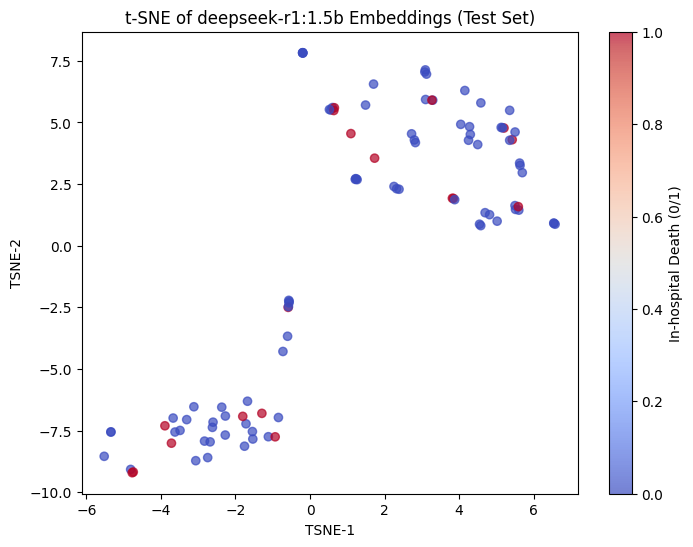

In [51]:
if run_efficient:
    train_X, train_y = build_embeddings(summaries_a_small, summary_col="summary_trend", model_name='deepseek-r1:1.5b')
    test_X, test_y = build_embeddings(summaries_b_small, summary_col="summary_trend", model_name='deepseek-r1:1.5b')
else: 
    train_X, train_y = build_embeddings(summaries_a, summary_col="summary_trend", model_name='deepseek-r1:1.5b')
    test_X, test_y = build_embeddings(summaries_b, summary_col="summary_trend", model_name='deepseek-r1:1.5b')

probs, auroc, auprc = train_and_evaluate(train_X, train_y, test_X, test_y)
print(f"Test AuROC: {auroc:.4f}, Test AuPRC: {auprc:.4f}")


if run_efficient:
    visualize_tsne(train_X, train_y, title="t-SNE of deepseek-r1:1.5b Embeddings (Test Set)")
else: 
    visualize_tsne(test_X, test_y, title="t-SNE of deepseek-r1:1.5b Embeddings (Test Set)")


# Q4.3 Using time-series foundation models

In [15]:
# If not installed yet:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to c:\users\tilma\appdata\local\temp\pip-req-build-h6u10xk3
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.2 MB 8.3 MB/s eta 0:00:02
   ------------- -------------------------- 3.4/10.2 MB 11.8 MB/s eta 0:00:01
   ------------------ --------------------- 4.7/10.2 MB 13.0 MB/s eta 0:00:01
   ------------------------- -------------- 6.6/10.2 MB 9.4 MB/s eta 0:00:01
   ---------------------------------------

  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git 'C:\Users\tilma\AppData\Local\Temp\pip-req-build-h6u10xk3'

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
np.random.seed(1)

a_ids_small = np.random.choice(df_a['RecordID'].unique(), size=100, replace=False)
df_a_small = df_a[df_a['RecordID'].isin(a_ids_small)]

b_ids_small = np.random.choice(df_b['RecordID'].unique(), size=10, replace=False)
df_b_small = df_b[df_b['RecordID'].isin(b_ids_small)]

In [64]:

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.float32,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

def get_univariate_embedding(pipeline, single_var_series):
    """
    Given a single univariate time series (1D array), return its Chronos embedding.
    """
    if not isinstance(single_var_series, torch.Tensor):
        series_tensor = torch.tensor(single_var_series, dtype=torch.float32)
    else:
        series_tensor = single_var_series.float()

    # Chronos supports single 1D tensors directly
    with torch.no_grad():
        embedding, _ = pipeline.embed(series_tensor)
    return embedding.mean(dim=0) # Average pooling

def compute_patient_embedding_naive(pipeline, multivar_data):
    """
    Given a dictionary of { variable_name: 1D time series } for a patient,
    compute the average embedding across variables.
    """
    embeddings = []

    for var_name, series in multivar_data.items():
        if len(series) == 0:
            continue
        emb = get_univariate_embedding(pipeline, series)
        embeddings.append(emb)

    if not embeddings:
        return torch.zeros(512)  # or whatever the embedding dim is

    return torch.stack(embeddings, dim=0).mean(dim=0)  # shape: [embedding_dim]

def build_patient_embeddings_naive(pipeline, df_timeseries, df_labels, variables):
    """
    Builds Chronos embeddings per patient using naive variable-wise averaging.

    Args:
        pipeline: ChronosPipeline instance
        df_timeseries: long-form time series DataFrame with columns:
                       ['RecordID', 'Time', var1, var2, ...]
        df_labels: DataFrame with columns ['RecordID', 'In-hospital_death']
        variables: list of variable names to embed (e.g., ['HeartRate', 'WBC'])

    Returns:
        X: numpy array of shape [num_patients, embedding_dim]
        y: numpy array of shape [num_patients]
    """
    X_list = []
    y_list = []

    for rid, group in df_timeseries.groupby("RecordID"):
        patient_data = {}

        for var in variables:
            if var in group.columns:
                series = group[var].dropna().values
                if len(series) > 0:
                    patient_data[var] = series

        if not patient_data:
            continue  # skip if no valid data

        emb = compute_patient_embedding_naive(pipeline, patient_data)
        X_list.append(emb.cpu().numpy())

        # Lookup label
        label_row = df_labels[df_labels['RecordID'] == rid]
        if not label_row.empty:
            y_list.append(label_row['In-hospital_death'].values[0])
        else:
            continue  # skip if label missing

    return np.vstack(X_list), np.array(y_list)


# 1) Single Embedding + Linear Probe
list_of_variables = ['Gender', 'Height', 'Weight', 'Age', 'Albumin',
       'Cholesterol', 'DiasABP', 'HCO3', 'HCT', 'HR', 'Mg', 'MAP', 'Na',
       'NIDiasABP', 'NIMAP', 'NISysABP', 'SysABP', 'PaCO2', 'PaO2',
       'Platelets', 'RespRate', 'Temp', 'ALP', 'ALT', 'AST', 'BUN',
       'Bilirubin', 'Creatinine', 'FiO2', 'GCS', 'Glucose', 'K', 'Lactate',
       'MechVent', 'Urine', 'WBC', 'pH', 'SaO2', 'TroponinT', 'TroponinI']


if run_efficient:
    train_X, train_y = build_patient_embeddings_naive(pipeline, df_a_small, death_a,list_of_variables)
    test_X, test_y = build_patient_embeddings_naive(pipeline, df_b_small, death_b, list_of_variables)
else: 
    train_X, train_y = build_patient_embeddings_naive(pipeline, df_a, death_a,list_of_variables)
    test_X, test_y = build_patient_embeddings_naive(pipeline, df_b, death_b, list_of_variables)

clf = LogisticRegression(max_iter=2000)
clf.fit(train_X, train_y)
probs = clf.predict_proba(test_X)[:,1]
auroc = roc_auc_score(test_y, probs)
auprc = average_precision_score(test_y, probs)
print(f"[Naive Aggregation] AuROC={auroc:.4f}, AuPRC={auprc:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [4699, 100]

In [65]:
train_X.shape

(4699, 512)

In [67]:
first_id = df_a['RecordID'].unique()[0]
patient_df = df_a[df_a['RecordID'] == first_id]
patient_df
#embedding = compute_patient_embedding_naive(pipeline, patient_df)
#embedding

,RecordID,Time,Gender,Height,Weight,Age,Albumin,Cholesterol,DiasABP,HCO3,...,Glucose,K,Lactate,MechVent,Urine,WBC,pH,SaO2,TroponinT,TroponinI
0,132539.0,2025-03-10 00:00:00,0.0,-0.953317,0.283445,-0.596332,1.004449,-0.069047,-0.739159,-1.269243,...,-0.708333,0.625,-0.583333,0.0,2.96,0.271429,-0.750,1.00,0.933333,-0.224490
1,132539.0,2025-03-10 01:00:00,0.0,-0.953317,0.283445,-0.596332,-0.232975,1.997003,0.232700,-2.924060,...,0.354167,0.375,-0.166667,0.0,3.20,0.000000,0.750,-15.50,-0.177778,0.408163
2,132539.0,2025-03-10 02:00:00,0.0,-0.953317,0.283445,-0.596332,-1.132919,2.628972,2.440210,0.385573,...,-0.708333,0.625,2.000000,0.0,-0.40,2.185714,-0.250,1.00,0.333333,-0.285714
3,132539.0,2025-03-10 03:00:00,0.0,-0.953317,0.283445,-0.596332,-0.120482,-1.721888,1.169851,-0.441835,...,0.250000,-1.000,-0.416667,0.0,0.72,2.185714,-0.250,0.50,0.333333,2.040816
4,132539.0,2025-03-10 04:00:00,0.0,-0.953317,0.283445,-0.596332,-0.120482,1.462261,-0.392067,-2.510356,...,0.854167,0.125,0.000000,0.0,-0.16,-0.957143,0.375,1.00,0.200000,0.795918
5,132539.0,2025-03-10 05:00:00,0.0,-0.953317,0.283445,-0.596332,1.341928,1.146276,-0.235875,0.178721,...,0.104167,-2.125,1.666667,0.0,-0.16,1.557143,-0.375,0.00,-0.244444,0.183673
6,132539.0,2025-03-10 06:00:00,0.0,-0.953317,0.283445,-0.596332,1.341928,-0.506564,-0.322648,-0.234983,...,0.854167,0.625,0.833333,0.0,0.72,1.557143,-0.125,0.00,0.800000,-0.081633
7,132539.0,2025-03-10 08:00:00,0.0,-0.953317,0.283445,-0.596332,-1.357905,-0.117660,-0.010265,1.419833,...,0.250000,-0.250,0.250000,0.0,0.32,-0.657143,-0.625,0.00,20.911111,8.408163
8,132539.0,2025-03-10 09:00:00,0.0,-0.953317,0.283445,-0.596332,-1.132919,0.344163,0.232700,-0.028131,...,0.083333,-0.250,-0.416667,0.0,0.00,-0.657143,-0.250,0.00,-0.088889,-0.020408
9,132539.0,2025-03-10 10:00:00,0.0,-0.953317,0.283445,-0.596332,-1.470399,0.076791,0.302119,0.385573,...,0.250000,-0.375,4.000000,0.0,0.16,-0.014286,-1.000,0.00,1.555556,0.040816


Making a smarter aggregation: 
Instead of simply averaging embeddings across variables, we can:

Compute an embedding for each variable.

Feed all variable embeddings into a small MLP that outputs a patient-level embedding.

Then, either attach a logistic head for classification or just produce a final embedding for a standard logistic regression.

In [ ]:

########################################
# 2) Simple Neural Aggregator Approach #
########################################

class ChannelAggregator(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=64, out_dim=1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim*10, hidden_dim),  # if you expect ~10 variables
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, x):
        return self.mlp(x)

def build_multivar_embeddings(pipeline, multivar_data):
    """
    For a single patient: build stacked embeddings for each variable using Chronos.
    Returns a tensor of shape [num_vars, embed_dim]
    """
    embeddings = []
    for var_name, series in multivar_data.items():
        if len(series) == 0:
            continue
        series_tensor = torch.tensor(series, dtype=torch.float32)
        with torch.no_grad():
            emb, _ = pipeline.embed(series_tensor)
        embeddings.append(emb.squeeze(0).unsqueeze(0))  # shape [1, embed_dim]

    if not embeddings:
        return torch.zeros((1, 512))  # fallback for empty case
    return torch.cat(embeddings, dim=0)  # shape [num_vars, embed_dim]

def train_aggregator(pipeline, aggregator, df_patients, epochs=5, lr=1e-3, device='cpu'):
    aggregator.to(device)
    optimizer = torch.optim.Adam(aggregator.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Precompute all embeddings
    X_list, y_list = [], []
    for _, row in df_patients.iterrows():
        emb_stack = build_multivar_embeddings(pipeline, row['multivar_data'])
        X_list.append(emb_stack.unsqueeze(0))  # [1, num_vars, embed_dim]
        y_list.append(row['label'])

    # Prepare tensors
    X_tensor = torch.cat(X_list, dim=0).float().to(device)  # [batch, num_vars, embed_dim]
    y_tensor = torch.tensor(y_list, dtype=torch.float).unsqueeze(-1).to(device)  # [batch, 1]

    for epoch in range(epochs):
        aggregator.train()
        optimizer.zero_grad()
        logits = aggregator(X_tensor)
        loss = criterion(logits, y_tensor)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss={loss.item():.4f}")

    return aggregator

def evaluate_aggregator(pipeline, aggregator, df_patients, device='cpu'):
    aggregator.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for _, row in df_patients.iterrows():
            emb_stack = build_multivar_embeddings(pipeline, row['multivar_data']).unsqueeze(0).to(device)
            logit = aggregator(emb_stack)
            all_logits.append(logit.item())
            all_labels.append(row['label'])

    all_logits = np.array(all_logits)
    all_labels = np.array(all_labels)
    probs = 1 / (1 + np.exp(-all_logits))  # Sigmoid to get probabilities

    auroc = roc_auc_score(all_labels, probs)
    auprc = average_precision_score(all_labels, probs)
    return auroc, auprc


aggregator = ChannelAggregator(embed_dim=128, hidden_dim=64, out_dim=1)
aggregator = train_aggregator(pretrained_model, aggregator, df_train, epochs=5, lr=1e-3, device='cpu')
auroc, auprc = evaluate_aggregator(pretrained_model, aggregator, df_test)
print(f"[Neural Aggregator] AuROC={auroc:.4f}, AuPRC={auprc:.4f}")